## CS310 Natural Language Processing
## Assignment 3 (part 2). Named Entity Recognition with Bi-LSTM

**Total points**: 30 + 20 bonus points

In this assignment, you will train a bidirectional LSTM model on the CoNLL2003 English named entity recognition task set and evaluate its performance.

For the bonus questions, submit them as separate notebook files.

### 0. Import Necessary Libraries

In [9]:
from typing import List
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

from pprint import pprint
from collections import Counter

from utils import CorpusReader
import re


In [ ]:
class Vocabulary:
    def __init__(self, min_freq=2):
        self.word2idx = {'<PAD>': 0, '<UNK>': 1, '<BOS>': 2, '<EOS>': 3}
        self.idx2word = {0: '<PAD>', 1: '<UNK>', 2: '<BOS>', 3: '<EOS>'}
        self.min_freq = min_freq
        
    def build_vocab(self, text):
        word_counts = Counter(text)
        valid_words = [word for word, count in word_counts.items() if count >= self.min_freq]
        
        for word in valid_words:
            if word not in self.word2idx:
                self.word2idx[word] = len(self.word2idx)
                self.idx2word[len(self.idx2word)] = word
                
    def __len__(self):
        return len(self.word2idx)

class TextDataset(Dataset):
    def __init__(self, text, vocab, seq_length):
        self.vocab = vocab
        self.seq_length = seq_length
        
        self.data = [self.vocab.word2idx.get(word, self.vocab.word2idx['<UNK>']) 
                    for word in text]
        
        self.sequences = []
        for i in range(0, len(self.data) - seq_length, 1):
            seq = self.data[i:i + seq_length]
            target = self.data[i + 1:i + seq_length + 1]
            self.sequences.append((seq, target))
            
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        seq, target = self.sequences[idx]
        return torch.LongTensor(seq), torch.LongTensor(target)

def load_and_preprocess_data(file_path, seq_length=35):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read().lower()
    
    words = text.split()
    vocab = Vocabulary(min_freq=2)
    vocab.build_vocab(words)
    
    split_idx = int(len(words) * 0.9)
    train_words = words[:split_idx]
    test_words = words[split_idx:]
    
    train_dataset = TextDataset(train_words, vocab, seq_length)
    test_dataset = TextDataset(test_words, vocab, seq_length)
    
    return train_dataset, test_dataset, vocab



### 1. Build the Model

In [ ]:
### 2. Model Implementation

class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout=0.5):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers, 
                         batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
    def forward(self, x, hidden=None):
        # x shape: [batch_size, seq_len]
        batch_size = x.size(0)
        
        if hidden is None:
            hidden = self.init_hidden(batch_size)
            
        embedded = self.dropout(self.embedding(x))
        output, hidden = self.rnn(embedded, hidden)

        output = self.dropout(output)
        output = self.fc(output)
        
        return output, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters())
        return weight.new_zeros(self.num_layers, batch_size, self.hidden_dim)


### 2. Train and Evaluate

In [ ]:
### 3. Training and Evaluation Functions

def train_model(model, train_loader, test_loader, criterion, optimizer, 
                num_epochs, device, print_every=100):
    train_losses = []
    test_perplexities = []
    best_perplexity = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        hidden = None
        
        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs, hidden = model(inputs, None)
            hidden = hidden.detach()  # 分离计算图

            loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)  # 梯度裁剪
            optimizer.step()
            total_loss += loss.item()
            
            if (i + 1) % print_every == 0:
                train_losses.append(total_loss / print_every)
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], '
                        f'Loss: {total_loss/print_every:.4f}')
                total_loss = 0
        

        test_perplexity = evaluate(model, test_loader, criterion, device)
        test_perplexities.append(test_perplexity)
        print(f'Epoch [{epoch+1}/{num_epochs}], Test Perplexity: {test_perplexity:.4f}')

        if test_perplexity < best_perplexity:
            best_perplexity = test_perplexity
            torch.save(model.state_dict(), 'best_rnn_model.pth')
        
    return train_losses, test_perplexities

def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs, hidden = model(inputs, None)
            outputs, hidden = model(inputs, hidden)
            loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
            total_loss += loss.item() * inputs.size(0)
    avg_loss = total_loss / len(test_loader.dataset)
    perplexity = np.exp(avg_loss)
    return perplexity

def generate_text(model, vocab, prefix, max_length=50, temperature=1.0):
    model.eval()
    words = prefix.lower().split()
    hidden = None
    
    with torch.no_grad():
        for i in range(max_length):
            curr_seq = torch.LongTensor([[vocab.word2idx.get(w, vocab.word2idx['<UNK>']) 
                                        for w in words[-1:]]])

            output, hidden = model(curr_seq, hidden)

            output_dist = output.div(temperature).exp()
            top_idx = torch.multinomial(output_dist.view(-1), 1)[0]
            
            predicted_word = vocab.idx2word[top_idx.item()]
            words.append(predicted_word)
            
            if predicted_word == '<EOS>':
                break
    
    return ' '.join(words)



Epoch [1/20], Step [100/1912], Loss: 7.3501
Epoch [1/20], Step [200/1912], Loss: 6.6263
Epoch [1/20], Step [300/1912], Loss: 6.3377
Epoch [1/20], Step [400/1912], Loss: 6.1658
Epoch [1/20], Step [500/1912], Loss: 6.0530
Epoch [1/20], Step [600/1912], Loss: 5.9645
Epoch [1/20], Step [700/1912], Loss: 5.8949
Epoch [1/20], Step [800/1912], Loss: 5.8345
Epoch [1/20], Step [900/1912], Loss: 5.7918
Epoch [1/20], Step [1000/1912], Loss: 5.7517
Epoch [1/20], Step [1100/1912], Loss: 5.7162
Epoch [1/20], Step [1200/1912], Loss: 5.6826
Epoch [1/20], Step [1300/1912], Loss: 5.6594
Epoch [1/20], Step [1400/1912], Loss: 5.6342
Epoch [1/20], Step [1500/1912], Loss: 5.6096
Epoch [1/20], Step [1600/1912], Loss: 5.5838
Epoch [1/20], Step [1700/1912], Loss: 5.5692
Epoch [1/20], Step [1800/1912], Loss: 5.5513
Epoch [1/20], Step [1900/1912], Loss: 5.5376
Epoch [1/20], Test Perplexity: 299.4060
Epoch [2/20], Step [100/1912], Loss: 5.5093
Epoch [2/20], Step [200/1912], Loss: 5.5001
Epoch [2/20], Step [300/19

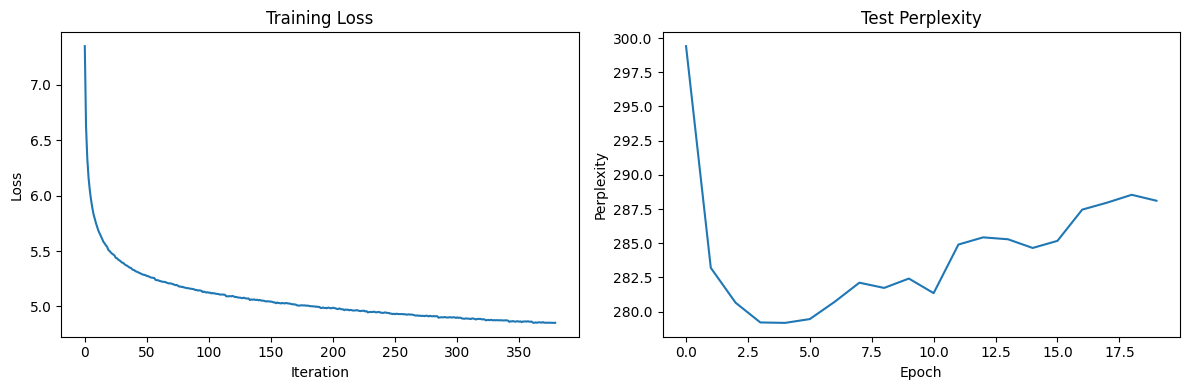

In [ ]:
### 4. Main Training Loop

# 设置参数
EMBEDDING_DIM = 200
HIDDEN_DIM = 256
NUM_LAYERS = 2
BATCH_SIZE = 512
NUM_EPOCHS = 20
LEARNING_RATE = 0.001
SEQUENCE_LENGTH = 35
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

file_path = './Harry_Potter_all_books_preprocessed.txt'
train_dataset, test_dataset, vocab = load_and_preprocess_data(file_path, SEQUENCE_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

model = RNNModel(len(vocab), EMBEDDING_DIM, HIDDEN_DIM, NUM_LAYERS).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses, test_perplexities = train_model(
    model, train_loader, test_loader, criterion, optimizer, 
    NUM_EPOCHS, DEVICE
)


Prefix: Harry looked at
Generated: harry looked at the bottom of the castle .but somehow seemed to share left said hagrid .you didnt cure snape .frustration .i might have been going back to power for something after in tonight .thank you a source of rotten which will have popped through the decree in the first year .you havent

Prefix: Harry looked over
Generated: harry looked over it or not having not had much to finish .mr weasley ?said dumbledore in disbelief but as he remembered the firebolt fell at him .explain no .all you need to get us said ginny s voice trembled with imminent influence of amusement at these .not i am afraid of the

Prefix: Harry looked around
Generated: harry looked around and headed deep around the street full of lanterns full of vapors .harry swept up for a few seconds before perhaps do it does ?said snape and about two times that fred looked up and harry in her stare .well but .i suppose a now arent you too every gettin

Prefix: Harry looked at the
Generate

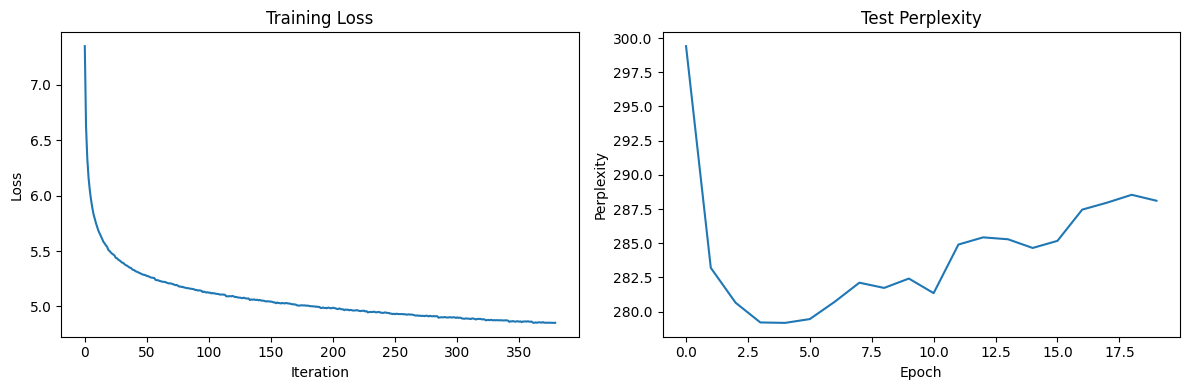

In [18]:
test_prefixes = [
    "Harry looked at",
    "Harry looked over",
    "Harry looked around",
    "Harry looked at the",
    "Harry looked at the door",
]

model = RNNModel(len(vocab), EMBEDDING_DIM, HIDDEN_DIM, NUM_LAYERS).to(DEVICE)
model.load_state_dict(torch.load('best_rnn_model.pth'))
model.to(DEVICE)
model.eval()

for prefix in test_prefixes:
    model = model.cpu();
    generated = generate_text(model, vocab, prefix);
    print(f"\nPrefix: {prefix}")
    print(f"Generated: {generated}")

# 绘制训练损失和测试困惑度曲线
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(test_perplexities)
plt.title('Test Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')

plt.tight_layout()
plt.show()